In [1]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Activation
#from keras.layers.core import Lambda
from keras import backend as K
import numpy as np
import os,sys
from math import ceil
from skimage.transform import resize

/Users/user/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 6
data_dir = "/Users/user/Desktop/cifar-10-batches-py"
CLASS_CNT = 1000

In [3]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [4]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu', kernel_initializer="he_uniform")(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(CLASS_CNT, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
# explore cifar-10 dataset
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10(root_dir, command="train"):
    labels = []
    filenames = []
    data_l = []
    if command == "train":
        batch_names = ["data_batch_1", 
                           "data_batch_2",
                           "data_batch_3",
                           "data_batch_4",
                           "data_batch_5"]
    elif command == "val":
        batch_names = ["test_batch"]
    else:
        raise 'not valid command, currently only "train" and "val" are supported'
    for batch_name in batch_names:
        raw_dict = unpickle(os.path.join(root_dir, batch_name))
        labels.extend(raw_dict[b'labels'])
        filenames.extend(raw_dict[b'filenames'])
        data_l.append(raw_dict[b"data"])
    data = np.concatenate(data_l)
    dataset = [{"filename": x, "label": y, "data": z} for x,y,z in zip(filenames, labels, data)]
    
    
    # load label list
    label_map = [x.decode("utf-8") for x in unpickle(os.path.join(root_dir, "batches.meta"))[b'label_names']]
    return label_map, dataset

def convert2hwc(img, resize_shape = None):
    # (3072,0) -> (3, 1024) -> (3, 32, 32) -t-> (3, 32, 32)
    img = img.reshape((3, 1024)).reshape((3, 32, 32))
    img = img.transpose((1,2,0)) 
    if resize_shape is not None:
        img = resize(img, resize_shape)
    return img

def np_one_hot(class_cnt, label):
    targets = np.array([label]).reshape(-1)
    return np.eye(class_cnt)[targets]

def data_generator(dataset, shuffle=True, batch_size=10):
    input_l, output_l, b = [], [], 0
    idx = 0
    data_size = len(dataset)
    while True:
        # shuffle at start of epoch
        if idx == 0 and shuffle:
            print("shuffling dataset")
            np.random.shuffle(dataset)
        
        # compose batch set
        input_l.append(convert2hwc(dataset[idx]["data"], resize_shape = (299,299,3)))
        output_l.append(dataset[idx]["label"])
        b += 1
        idx += 1
        
        if b == batch_size:
            yield np.asarray(input_l), np_one_hot(CLASS_CNT, output_l)
            # re-init
            input_l, output_l, b = [], [], 0
            
        # here is end of epoch
        if idx == data_size:
            idx = 0

In [6]:
label_map, train_set = load_cifar10(data_dir, "train")
_, val_set = load_cifar10(data_dir, "val")
train_g = data_generator(train_set, shuffle=True, batch_size=batch_size)
val_g = data_generator(train_set, shuffle=True, batch_size=batch_size)

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

shuffling dataset
(299, 299, 3)
(1000,)


/Users/user/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


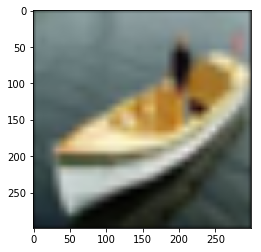

In [7]:
import  matplotlib.pyplot as plt
img, label = next(train_g)
print(img[0].shape)
print(label[0].shape)
plt.imshow(img[0])
plt.show()

In [8]:
# train the model on the new data for a few epochs
model.fit_generator(
            generator=train_g,
            initial_epoch=0,
            epochs=1,
            steps_per_epoch=ceil(len(train_set) / batch_size),
            validation_data=val_g,
            validation_steps=ceil(len(val_set) / batch_size),
        )

Epoch 1/1


/Users/user/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


  30/8334 [..............................] - ETA: 9:51:33 - loss: 3.9588

KeyboardInterrupt: 

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit_generator(
            generator=train_g,
            initial_epoch=0,
            epochs=1,
            steps_per_epoch=ceil(len(train_set) / batch_size),
            validation_data=val_g,
            validation_steps=ceil(len(val_set) / batch_size),
        )